## **Прогнозирование количество заказов такси на следующий час**

**Цель исследования:**

Построить модель для прогнозирования количества заказов такси на следующий час. При оценке качества использовать метрику RMSE.

**Ход исследования:**
- Загрузка и подготовка данных.
- Обучение разных моделей и поиск лучшей.
- Проведение анализа качества модели





In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor as lgbr
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings("ignore")

## 1. Загрузите и подготовьте данные

### 1.1. Обзор данных

In [19]:
try:
  data = pd.read_csv("/datasets/taxi.csv", error_bad_lines=False,  parse_dates=['datetime'])
except:
  data=pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', error_bad_lines=False,  parse_dates=['datetime'])
display(data.head())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [20]:
print("Пропусков в данных:")
print(data.isna().sum())
print()

print("Дубликатов в данных:")
print(data.duplicated().sum())

Пропусков в данных:
datetime      0
num_orders    0
dtype: int64

Дубликатов в данных:
0


Пропусков и дубликатов в данных не обнаружено, данные подходят для дальнейшей работы с ними.

### 1.2. Ресемплирование данных

In [21]:
data = data.set_index('datetime')
data.sort_index(inplace=True)
data_hour = data.resample('1H').sum()
data_month= data.resample('1M').sum()
data_week = data.resample('1W').sum()

Произведем ресемплирование по часу, неделе и месяцу, чтобы проанализировать данные.

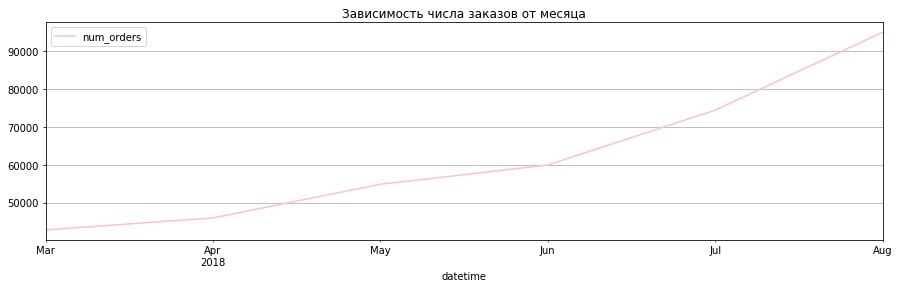

In [22]:
data_month.plot(figsize=(15,4), grid = "on", color = "pink")
plt.title('Зависимость числа заказов от месяца')
plt.show()

Начиная с июня наблюдаем значительный рост числа заказов, при этом общая динамика возрастающая на протяжении всего рассматриваемого периода.

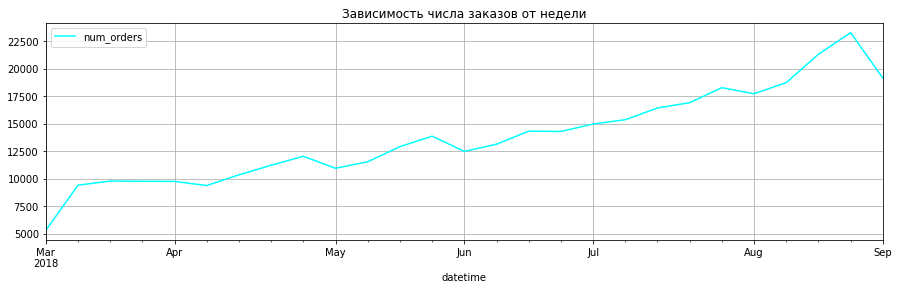

In [23]:
data_week.plot(figsize=(15,4), grid = "on", color = "cyan")
plt.title('Зависимость числа заказов от недели')
plt.show()

Пиковое число заказов приходится на третью неделю августа. Затем мы наблюдаем падение числа заказов до значения на момент начала второй недели.

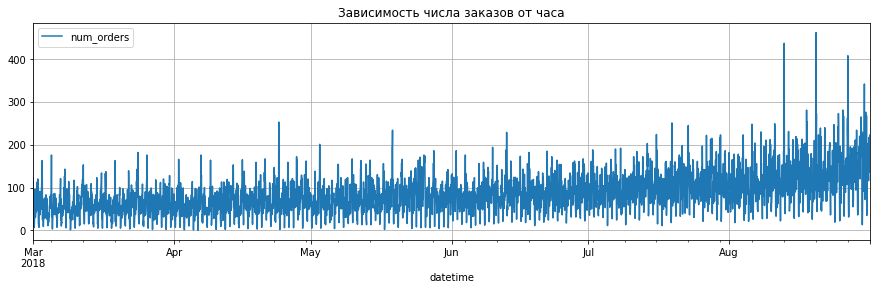

In [24]:
data_hour.plot(figsize=(15,4), grid = "on")
plt.title('Зависимость числа заказов от часа')
plt.show()

В некоторые отдельные часы в августе число заказов превышает значение 400.

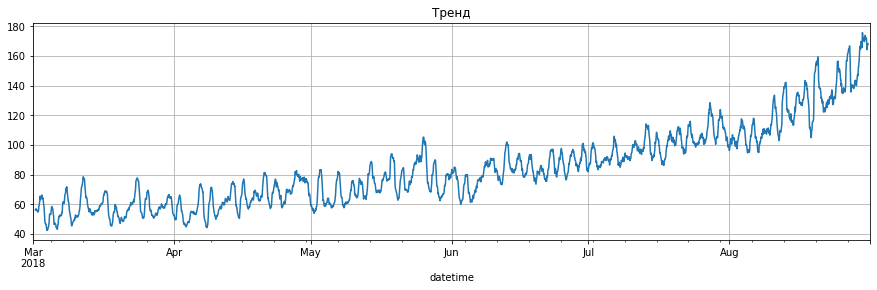

In [25]:
decomposed = seasonal_decompose(data_hour)

decomposed.trend.plot(ax=plt.gca(),figsize=(15,4), grid="on")
plt.title('Тренд')
plt.show()

На графике тренда видим, что тренд восходящий, начиная с июня месяца значительно возрастающий

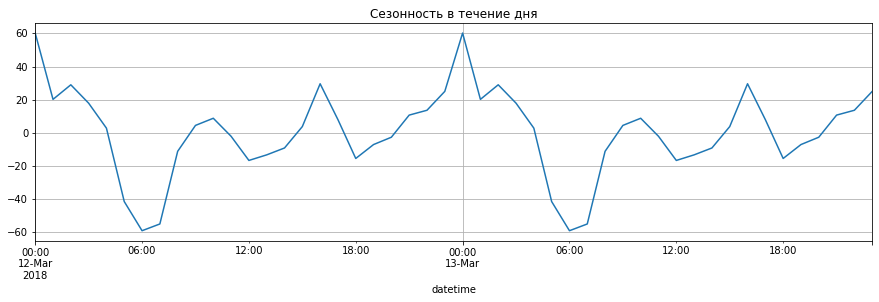

In [26]:
decomposed.seasonal['2018-03-12':'2018-03-13'].plot(ax=plt.gca(),figsize=(15,4), grid="on")
plt.title('Сезонность в течение дня')
plt.show()

Самое пиковое время заказов такси в 0 часов, самое маленькое число заказов наблюдается в 6 утра.

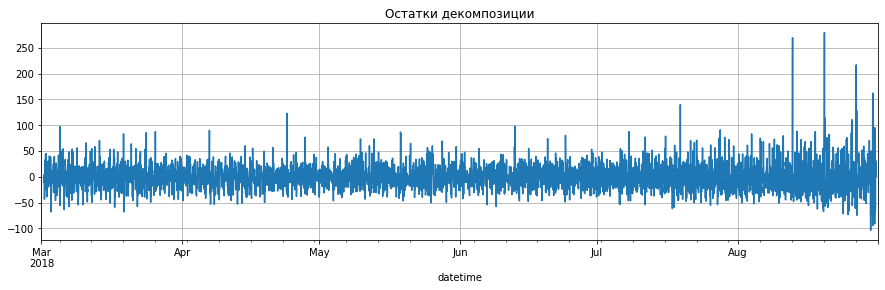

In [27]:
decomposed.resid.plot(ax=plt.gca(),figsize=(15,4), grid="on")
plt.title('Остатки декомпозиции')
plt.show()

По итогу анализа данных видим, что на число заказов напрямую влияет само время заказа, а также день недели, в который делают заказ. Используем полученные данные для создания признаков.

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [29]:
make_features(data_hour, 200, 30)
display(data_hour.head(5))
data.shape

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(26496, 1)

## 2. Обучение модели.

### 2.1. Разделение на тренировочную и тестовую выборки




In [30]:
train, test = train_test_split(data_hour, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis = 1)
test_features = test.drop(['num_orders'], axis = 1)
train_target = train['num_orders']
test_target = test['num_orders']


### 2.2. Обучение разных моделей с подбором гиперпараметров и поиск лучшей.

#### 2.3.1 Линейная регрессия с L1 и L2 регуляризацией

До подбора гиперпараметров

In [31]:
model = ElasticNet()# < обучите модель >
model.fit(train_features, train_target)
predictions_t = model.predict(train_features)
predictions_f = model.predict(test_features)
 
print("RMSE обучающей выборки:", np.sqrt(mean_squared_error(train_target, predictions_t)))
print("RMSE тестовой выборки: ", np.sqrt(mean_squared_error(test_target, predictions_f)))

RMSE обучающей выборки: 20.136231178166657
RMSE тестовой выборки:  34.23475613656576


После подбора гиперпараметров

In [ ]:
tscv = TimeSeriesSplit(n_splits = 10)
parametersGrid = {"alpha": [ 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.1, 0.1)}
gr_s = GridSearchCV(model, parametersGrid, scoring = 'neg_mean_squared_error', cv=tscv)
gr_s.fit(train_features, train_target)
print("Лучшие параметры модели: ", gr_s.best_params_)
print("RMSE тестовой выборки: ", np.sqrt(gr_s.best_score_*(-1)))

#### 2.3.2 LightGBM

До подбора гиперпараметров

In [ ]:
model = lgbr()
model.fit(train_features, train_target)
test_predictions = model.predict(test_features)

print("Значение RMSE на валидационной выборке:", np.sqrt(mean_squared_error(test_target, test_predictions)))

После подбора гиперпараметров

In [ ]:
#(reg_alpha=0.3, num_leaves=30, n_estimators=180)37.43
model = lgbr()
params = {"reg_alpha" :[0.1, 0.2, 0.3],
          "num_leaves" : [10, 20, 30],
          "n_estimators" : [150, 180, 200]}
gr_s = GridSearchCV(model, params, scoring = 'neg_mean_squared_error', cv=tscv)
gr_s.fit(train_features, valid_target)
print("Лучшие параметры модели: ", gr_s.best_params_)
print("RMSE валидационной выборки: ", np.sqrt(gr_s.best_score_*(-1)))

По итогу раздела лучшим образом показала себя линейная модель с L1 и L2 регуляризацией, значение метрики RMSE на валидационной выборке  составило 28.

### 3. Применение лучшей модели к тестовой выборке.

In [ ]:
model = ElasticNet()
model.fit(train_features, train_target)
test_predictions= model.predict(test_features)
print("Значение RMSE на тестовой выборке:", np.sqrt(mean_squared_error(test_target, test_predictions)))


### 4. Выводы.

Задачей исследования было построение модели прогнозирования количества заказов такси на следующий час. Значение метрики RMSE не должно превышать 58.

В ходе исследования были изучены предоставленные данные, произведена проверка на пропуски, дубликаты, ресепмплирование данных и генерация признаков.

Были рассмотрены две регрессионных модели: линейная регрессия с L1 и L2 регуляризацией и ансамблевая модель LightGBM. Для моделей при помощи при помощи перебора по сетке с использованием кросс-валидации, был осуществлен подбор гиперпараметров.

По итогам исследования худший результат показала модель **LightGBM**. Значение метрики на валидационной выборке при использовании модели составляет **30.04**. 

Самой сильной оказалась модель **линейной регрессии с регуляризацией**. Более простая модель для имющихся данных оказалась способна увидеть зависимости в них. Значение метрики составило на валидационном множестве **28.05**. После применения модели на тестовых данных значение метрики составило **34.6**

Рекомендации: Модель ElasticNet обладает хорошей точностью предсказания и малым временем обучения. Для получения более надежных предсказаний стоит учитывать сезонность и тренды в данных, а также иметь представление о зависимости каких-то внешних событий на число заказов такси.